In [1]:
## Import and authenticate
import ee
ee.Authenticate()
ee.Initialize()

Enter verification code: 4/1AX4XfWhIUzQ3Ipd3xVtvwKBaZ_7Jmkrhzo-yI-2vg5uMSPlNjI8l2q1PA1E

Successfully saved authorization token.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import geemap

In [7]:
l8 = ee.ImageCollection("LANDSAT/LC08/C01/T1_SR")
geometry = ee.Geometry.Polygon([[[-51.59926298236183,-0.3129106811885803],
                                 [-50.77528837298683,-0.3129106811885803],
                                 [-50.77528837298683,0.4835908106175574],
                                 [-51.59926298236183,0.4835908106175574],
                                 [-51.59926298236183,-0.3129106811885803]]])

#Filtering date, polygon, and cloudiness
images = (l8.filterDate('2015-09-01', '2022-01-01')
          .filterBounds(geometry)
          .filter('CLOUD_COVER < 30'))

#NDVI calculation:
def ndvi_func(i):
    ndvi = i.normalizedDifference (['B5', 'B4']).rename('NDVI')
    return i.addBands(ndvi)

images_ndvi = images.map(ndvi_func)

#EVI calculation:
def evi_func(i):
    EVI = i.expression('2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
        'NIR' : i.select('B5'),
        'RED' : i.select('B4'),
        'BLUE': i.select('B2')}).rename('EVI')
    
    return i.addBands(EVI)
    
images_evi = images.map(evi_func)

#Calculating year wise NDVI.  Result is a list of dictionaries.
years = ee.List.sequence(2015,2021)
def year_func_NDVI(y):
    range = ee.Filter.calendarRange (y, y, 'year')
    mean_ndvi = (images_ndvi
            .filter(range)
            .select('NDVI')
            .median()
            .reduceRegion(ee.Reducer.median(), geometry, 30))
    
    return mean_ndvi.set('year', y)
    
def year_func_EVI (z):
    range = ee.Filter.calendarRange (z, z, 'year')
    mean_evi = (images_evi
               .filter(range)
               .select('EVI')
               .median()
               .reduceRegion(ee.Reducer.median(),geometry,30))
    
 
    return mean_evi.set('year',z)
    
yearwise_NDVI = years.map(year_func_NDVI).getInfo()
yearwise_EVI = years.map(year_func_EVI).getInfo()
df_NDVI = pd.DataFrame(yearwise_NDVI)
df_EVI = pd.DataFrame(yearwise_EVI)
print(df_NDVI)
print(df_EVI)

       NDVI  year
0  0.574222  2015
1  0.441514  2016
2  0.542940  2017
3  0.511688  2018
4  0.621089  2019
5  0.597651  2020
6  0.582021  2021
        EVI  year
0  1.761912  2015
1  2.868358  2016
2  2.179249  2017
3  2.206762  2018
4  1.781416  2019
5  1.971618  2020
6  2.700256  2021


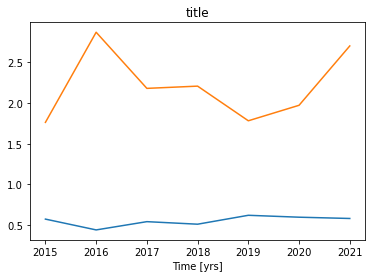

In [8]:
# Plot graphs

plt.plot(df_NDVI.year,df_NDVI.NDVI)
plt.plot(df_EVI.year,df_EVI.EVI)
plt.title('title')
plt.ylabel('')
plt.xlabel('Time [yrs]')
plt.show()

In [9]:
## Add map
Map = geemap.Map()

vis_params = {
    'min': 0,
    'max': 1,
    'palette': ['red', 'yellow','green'],
}

first_image = images_ndvi.select('NDVI').first()

Map.addLayer(first_image, vis_params, "First image")
Map.centerObject(geometry,8)

Map

Map(center=[0.08534089636841959, -51.187275677674215], controls=(WidgetControl(options=['position', 'transpare…

In [13]:
### Different yearly maps
## 2015 NDVI
ndvi_2015 = images_ndvi.filterDate('2015-01-01', '2016-01-01').select('NDVI').median()

## 2016 NDVI
ndvi_2016 = images_ndvi.filterDate('2016-01-01', '2017-01-01').select('NDVI').median()

## 2017 NDVI
ndvi_2017 = images_ndvi.filterDate('2017-01-01', '2018-01-01').select('NDVI').median()

## 2018 NDVI
ndvi_2018 = images_ndvi.filterDate('2018-01-01', '2019-01-01').select('NDVI').median()

## 2019 NDVI
ndvi_2019 = images_ndvi.filterDate('2019-01-01', '2020-01-01').select('NDVI').median()

## 2020 NDVI
ndvi_2020 = images_ndvi.filterDate('2020-01-01', '2021-01-01').select('NDVI').median()

## 2021 NDVI
ndvi_2021 = images_ndvi.filterDate('2021-01-01', '2022-01-01').select('NDVI').median()

Map = geemap.Map()

vis_params = {
    'min': 0,
    'max': 1,
    'palette': ['red', 'yellow','green'],
}                       
    
Map.addLayer(ndvi_2015, vis_params, "2015 NDVI")
Map.addLayer(ndvi_2016, vis_params, "2016 NDVI")
Map.addLayer(ndvi_2017, vis_params, "2017 NDVI")
Map.addLayer(ndvi_2018, vis_params, "2018 NDVI")
Map.addLayer(ndvi_2019, vis_params, "2019 NDVI")
Map.addLayer(ndvi_2020, vis_params, "2020 NDVI")
Map.addLayer(ndvi_2021, vis_params, "2021 NDVI")
Map.centerObject(geometry,8)

Map



Map(center=[0.08534089636841959, -51.187275677674215], controls=(WidgetControl(options=['position', 'transpare…